---
title: ベースラインを計算する
date: 2024-01-06
tags: [python, baseline]
exports:
    - format: pdf
    - format: typst
---

+++ {"part": "abstract"}

2023年12月に取得した宇宙線の同時計測イベントの波形データを解析しました。
波形データからベースラインを計算し、データを補正できることを確認しました。

+++

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib as mt
# import matplotlib.pyplot as plt

print(f"Pandas = {pd.__version__}")
print(f"Matplotlib = {mt.__version__}")

Pandas = 2.1.4
Matplotlib = 3.8.2


# データを読み込む（復習）

前のノートブックの処理を結果を復習しましょう

1. データを読み込むときにカラム名を指定する（``names``を設定）
2. 元ファイルの最初の行は不要なるので除外する（``skiprows=1``を指定）
3. 時刻カラムの値を反転する
4. ファイルを保存する（ファイル名は``data_01.csv``）

In [2]:
fname = Path("scopeData-2.csv")
names = ["time", "ch1", "ch2"]
data = pd.read_csv(fname, names=names, skiprows=1)
data["time"] = -data["time"]
data.to_csv("data_01.csv", index=False)
data.head()

time       ch1       ch2
0 -5.000  0.598145 -3.817139
1 -4.990  0.613046 -3.795718
2 -4.980  0.627947 -3.774298
3 -4.971  0.642848 -3.752877
4 -4.961  0.657749 -3.731457

<Axes: title={'center': 'Waveform of CH2'}, xlabel='time', ylabel='ch2'>

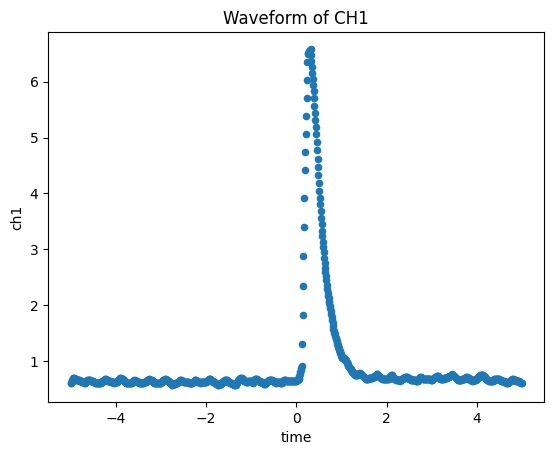

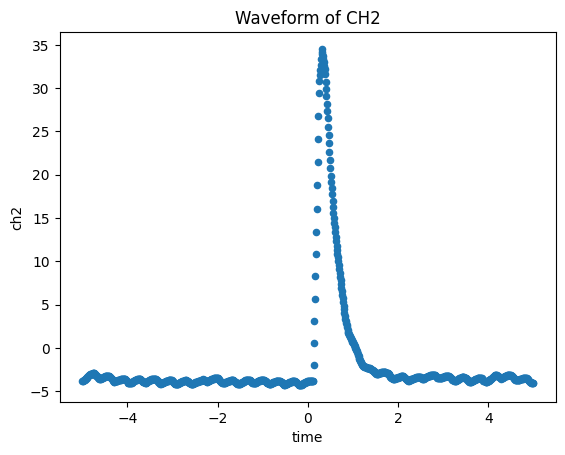

In [3]:
data.plot.scatter(x="time", y="ch1", title="Waveform of CH1")
data.plot.scatter(x="time", y="ch2", title="Waveform of CH2")

# ベースラインを計算する

波形データのベースライン計算します。
今回は、よくある計算方法のひとつである、最初の数点の平均値を使ってベースラインを定義します。
ついでに、ベースラインの広がりを計算します。

In [4]:
_mean: float = data["ch1"][:100].mean()
_std: float = data["ch1"][:100].std()

print(f"Ch1のベースライン: {_mean:.2f} +/- {_std:.2f}")

Ch1のベースライン: 0.64 +/- 0.02


Ch1のベースラインは $0.64 \pm 0.02$ mV と計算できました。
Ch2のベースラインも同様に計算します。

In [5]:
_mean: float = data["ch2"][:100].mean()
_std: float = data["ch2"][:100].std()

print(f"Ch2のベースライン: {_mean:.2f} +/- {_std:.2f}")

Ch2のベースライン: -3.47 +/- 0.27


Ch2のベースラインは $-3.47 \pm 0.27$ mV と計算できました。

## 同じ計算は**関数**にまとめる

ベースラインの平均値と広がりの計算のように、同じ内容の計算を繰り返す場合は、オリジナルの関数を作成するとよいです。

In [6]:
def get_baseline(data: pd.DataFrame, name: str, points: int = 100):
    """ベースラインの平均値と分散を取得する

    Args:
        data (pd.DataFrame): 波形データ
        name (str): カラム名. "ch1" や "ch2" などの波高値のデータを想定している
        points (str, optional): 計算に使うデータ数. Defaults to 100.
    
    Returns:
        float: 平均値
        float: 標準偏差
    """
    base: pd.Series = data[name].iloc[:points]
    mean: float = base.mean() # 平均値
    std: float = base.std()   # 標準偏差

    print(f"{name}: {mean:.2f} +/- {std:.2f}")
    return mean, std



In [7]:
mean1, std1 = get_baseline(data, name="ch1")
mean2, std2 = get_baseline(data, name="ch2")

ch1: 0.64 +/- 0.02
ch2: -3.47 +/- 0.27


# ベースラインを補正する

計算したベースラインの値を使って、波形データを補正します。
具体的には、チャンネルの波高値とベースライン値の差分を計算します（＝引き算する）。
これをそれぞれのチャンネルで計算します。

``pandas``のデータフレームは、以下の計算式で一括して差分計算できます。

In [8]:
data["ch1_fixed"] = data["ch1"] - mean1
data["ch2_fixed"] = data["ch2"] - mean2
data

time       ch1       ch2  ch1_fixed  ch2_fixed
0    -5.000  0.598145 -3.817139  -0.038933  -0.351046
1    -4.990  0.613046 -3.795718  -0.024032  -0.329625
2    -4.980  0.627947 -3.774298  -0.009131  -0.308205
3    -4.971  0.642848 -3.752877   0.005770  -0.286784
4    -4.961  0.657749 -3.731457   0.020671  -0.265364
...     ...       ...       ...        ...        ...
1019  4.951  0.619901 -4.007900  -0.017177  -0.541807
1020  4.961  0.615245 -4.025595  -0.021833  -0.559502
1021  4.971  0.610588 -4.043290  -0.026490  -0.577197
1022  4.980  0.605932 -4.060985  -0.031146  -0.594892
1023  4.990  0.606032 -4.047165  -0.031046  -0.581072

[1024 rows x 5 columns]

<Axes: title={'center': 'Waveform of CH2 (baseline adjusted)'}, xlabel='time', ylabel='ch2_fixed'>

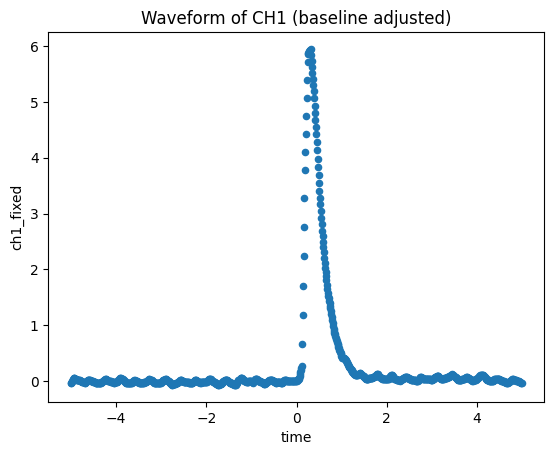

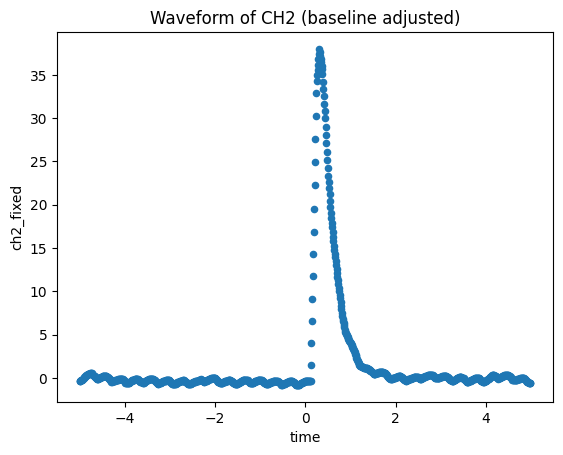

In [9]:
data.plot.scatter(x="time", y="ch1_fixed", title="Waveform of CH1 (baseline adjusted)")
data.plot.scatter(x="time", y="ch2_fixed", title="Waveform of CH2 (baseline adjusted)")

ベースライン補正ができているかを確認します。
ここでも、さきほど作成した``get_baseline``関数を再利用できます。
波高値の入ったデータのカラム名を受け取ることができるので、
そのまま``ch1_fixed``、``ch2_fixed``を指定します。

In [10]:
_mean1, _std1 = get_baseline(data, name="ch1_fixed")
_mean2, _std2 = get_baseline(data, name="ch2_fixed")

ch1_fixed: -0.00 +/- 0.02
ch2_fixed: -0.00 +/- 0.27


それぞれのベースラインが``0``になっていることが確認できました。

# データを保存する

ベースラインを補正したデータフレームを、CSV形式で保存します。
ファイル名は``data_0.csv``とします（ベースラインを0に補正したという意味を持たせたつもりです）。

In [11]:
fname = "data_02.csv"
data.to_csv(fname, index=False)

# おまけ：ベースラインの計算に最適なデータ数を考える

最初の100点を使ってベースラインの計算しましたが、これでよいのか、確認する。
計算に使うデータ数を、100、200、300、400、500と変化させて、ベースラインの値を確認する。

ch1: 0.66 +/- 0.03
ch2: -3.70 +/- 0.09
ch1: 0.64 +/- 0.02
ch2: -3.34 +/- 0.24
ch1: 0.64 +/- 0.02
ch2: -3.51 +/- 0.30
ch1: 0.64 +/- 0.02
ch2: -3.60 +/- 0.29
ch1: 0.63 +/- 0.02
ch2: -3.66 +/- 0.29
ch1: 0.63 +/- 0.03
ch2: -3.73 +/- 0.30
ch1: 0.63 +/- 0.02
ch2: -3.72 +/- 0.28
ch1: 0.63 +/- 0.03
ch2: -3.75 +/- 0.27
ch1: 0.63 +/- 0.03
ch2: -3.77 +/- 0.26
ch1: 0.63 +/- 0.03
ch2: -3.79 +/- 0.26
ch1: 0.63 +/- 0.03
ch2: -3.82 +/- 0.26
ch1: 0.92 +/- 1.18
ch2: -2.05 +/- 7.36
ch1: 1.04 +/- 1.23
ch2: -1.10 +/- 7.96
ch1: 1.03 +/- 1.18
ch2: -1.12 +/- 7.66
ch1: 1.01 +/- 1.14
ch2: -1.25 +/- 7.40
ch1: 0.99 +/- 1.11
ch2: -1.40 +/- 7.17
ch1: 0.97 +/- 1.08
ch2: -1.52 +/- 6.96
ch1: 0.95 +/- 1.05
ch2: -1.63 +/- 6.77
ch1: 0.94 +/- 1.02
ch2: -1.74 +/- 6.60
ch1: 0.93 +/- 0.99
ch2: -1.84 +/- 6.44
ch1: 0.91 +/- 0.97
ch2: -1.92 +/- 6.29


<Axes: title={'center': 'Baseline of Ch2'}, xlabel='points', ylabel='mean2'>

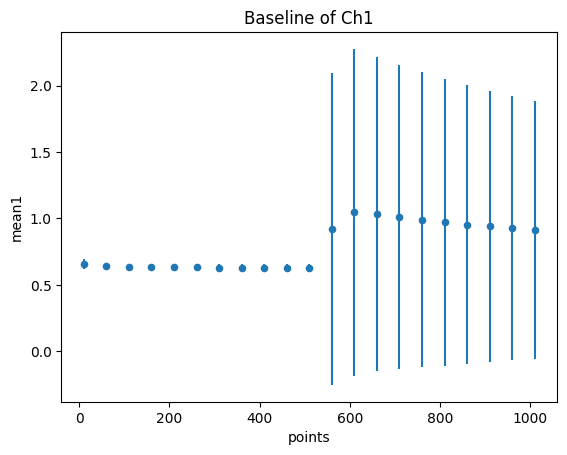

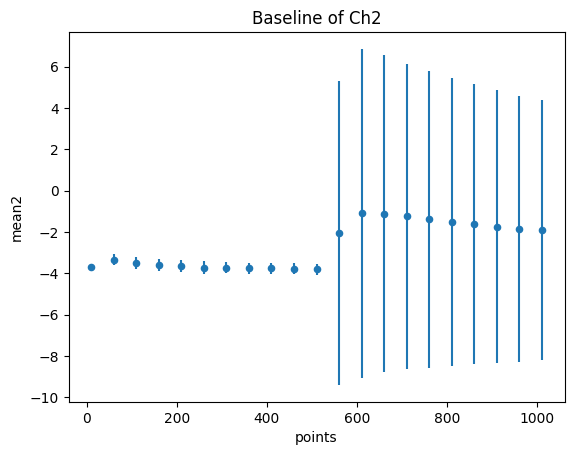

In [12]:
# n_points = [100, 200, 300]
n_points = [n for n in range(10, len(data), 50)]

_items = []
for points in n_points:
    mean1, std1 = get_baseline(data, name="ch1", points=points)
    mean2, std2 = get_baseline(data, name="ch2", points=points)

    _item: dict = {}
    _item["points"] = points
    _item["mean1"] = mean1
    _item["std1"] = std1
    _item["mean2"] = mean2
    _item["std2"] = std2

    _items.append(_item)

baselines = pd.DataFrame(_items)
baselines.plot.scatter(x="points", y="mean1", yerr="std1", title="Baseline of Ch1")
baselines.plot.scatter(x="points", y="mean2", yerr="std2", title="Baseline of Ch2")

500点くらいまでは、ベースラインの計算に利用できることが分かりました。